# Exploring Different Prompts

A range of prompts was systematically investigated to assess whether there was a significant improvement in performance with alternative prompt formulations. To derive some of these prompts, ChatGPT was utilized to analyze both the transcript and ground truth, with the objective of generating optimal prompts for a model to extract quotes from the given transcript. The prompt that yielded the highest performance score of 31.3% was one that requested a list of punchlines. In the context of stand-up comedy, punchlines are generally considered to be the most humorous segments of a performance. Thus, this result is consistent with the inherent nature of stand-up comedy sets and aligns with the goal of identifying the most impactful and comedic quotes.

In [2]:
import pandas as pd
from thefuzz import fuzz

def bipartite_metric(model_answers: pd.DataFrame, ground_truth: pd.DataFrame):  
    # Find the similarity of the model answers and ground truth by using fuzzy string matching
    score_matrix = model_answers.apply(
        lambda row_model: ground_truth.apply(
            lambda row_truth: 
                fuzz.ratio(row_truth["sentence"], row_model["sentence"]) 
                if row_model["comedian"] == row_truth["comedian"] 
                else None,
        axis=1),
    axis=1) \
        .melt(ignore_index=False) \
        .dropna() \
        .reset_index()
    
    # Find the best score by taking the maximum value
    best_match = score_matrix.loc[score_matrix.groupby("index")["value"].idxmax()].reset_index(drop=True)
    
    # Add in the ground truths that were not matched
    missing_gt = set(ground_truth.index) - set(best_match["variable"].unique())
    missing_gt = pd.DataFrame({"index": None, "variable": list(missing_gt), "value": 0})
    
    result = best_match.append(missing_gt).groupby("variable").mean().rename(columns={"value": "score"})
    
    # Calculate penalty for over generation 
    over_generation_penalty = len(model_answers) - len(ground_truth)
    penalty_factor = max(over_generation_penalty, 0)  
    
    # Add in the comedians and group by the mean for each comedian
    final_result = result.merge(ground_truth[['comedian']], left_index=True, right_index=True).reset_index(drop=True)
    comedian_scores = final_result.groupby('comedian')['score'].mean().reset_index()
    
    # Apply penalty to the final score, if penalty goes under 0, score is set to 0
    comedian_scores['score'] -= penalty_factor * 0.1 
    comedian_scores['score'] = comedian_scores['score'].apply(lambda x: max(x, 0))
    
    return comedian_scores

#### Imports

In [3]:
import sys
import pandas as pd
sys.path.append("..")
import seaborn as sns
import nltk
from thefuzz import fuzz
import matplotlib.pyplot as plt

from humor.bipartite_metric import bipartite_metric

In [4]:
ground_truth = pd.read_csv('/home/ada/humor/data/stand_up_dataset/standup_data.csv')
gemma = pd.read_csv('/home/ada/humor/data/stand_up_dataset/gemma_answers.csv')
laugh = pd.read_csv('/home/ada/humor/data/stand_up_dataset/prompts/laugh_prompt - Sheet1.csv')
punchline = pd.read_csv('/home/ada/humor/data/stand_up_dataset/prompts/punchline_prompt - Sheet1.csv')
most_laugh = pd.read_csv('/home/ada/humor/data/stand_up_dataset/prompts/mostlaugh_prompt - Sheet1.csv')

#### Experiment

In [5]:
gemma_metric = bipartite_metric(gemma, ground_truth)
gemma_metric.mean()

/tmp/ipykernel_2328989/272763274.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  gemma_metric.mean()


score    30.08505
dtype: float64

##### "The following is a stand-up comedy transcript. When performed in front of a live audience, which jokes do you think made the audience laugh?  List of quotes:"

In [6]:
laugh_metric = bipartite_metric(laugh, ground_truth)
laugh_metric.mean()

/tmp/ipykernel_2328989/1272076827.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  laugh_metric.mean()


score    27.421237
dtype: float64

##### The following is a stand-up comedy transcript. What are the funniest punchlines from the transcript. List of quotes:"

In [7]:
punchline_metric = bipartite_metric(punchline, ground_truth)
punchline_metric.mean()

/tmp/ipykernel_2328989/1365989135.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  punchline_metric.mean()


score    31.184944
dtype: float64

##### Below is a transcript from a stand-up comedy routine. Analyze the transcript and extract the quotes that are most likely to have made the audience laugh. List of quotes:

In [8]:
most_laugh_metric = bipartite_metric(most_laugh, ground_truth)
most_laugh_metric.mean()

/tmp/ipykernel_2328989/3481905512.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  most_laugh_metric.mean()


score    28.040908
dtype: float64

<Figure size 500x500 with 0 Axes>

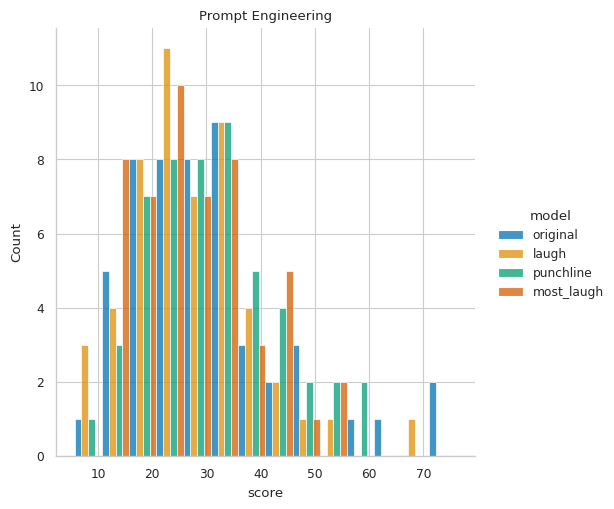

In [9]:
sns.set_style("whitegrid")
sns.set_context("paper")
plt.figure(figsize=(5, 5))  
sns.set_palette("colorblind")

original = gemma_metric.assign(model="original")
laugh = laugh_metric.assign(model="laugh") 
punchline = punchline_metric.assign(model="punchline")
most_laugh = most_laugh_metric.assign(model="most_laugh")

df = pd.concat([original, laugh, punchline, most_laugh]).reset_index(drop=True)
sns.displot(df, x="score", hue="model", kind="hist", shrink=1, multiple="dodge")
plt.title("Prompt Engineering")
plt.show()